In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Merge, TimeDistributed, LSTM, RepeatVector
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, ZeroPadding1D, Convolution3D, MaxPooling3D, AveragePooling3D
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping
from keras.layers import Input, merge, UpSampling3D
from keras.models import Model
from keras import backend as K
from keras import objectives
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np

Using TensorFlow backend.
C:\Program Files\Anaconda3\envs\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
input_shape = (1521, )
output_shape = 2

In [3]:
data = pd.read_csv('./fc_data.csv', header = None)

In [4]:
train, test = train_test_split(data, train_size=0.9, random_state=0)
x_train, x_test = train.iloc[:,1:].values, test.iloc[:,1:].values
y_test = np_utils.to_categorical(test.iloc[:,0].values)

In [5]:
x_train = x_train.reshape(x_train.shape[0], 39, 39, 1)
x_test = x_test.reshape(x_test.shape[0], 39, 39, 1)

In [6]:
from keras.layers.convolutional import Deconvolution3D, Conv3DTranspose, UpSampling2D, Deconvolution2D

In [7]:
x = Input(shape=(39, 39, 1))

conv1 = (Convolution2D(64, 6, 6, border_mode='valid', activation='relu'))(x)
conv2 = (Convolution2D(64, 6, 6, border_mode='valid', activation='relu'))(conv1)
conv3 = (Convolution2D(64, 6, 6, border_mode='valid', activation='relu'))(conv2)
maxpool = (MaxPooling2D(pool_size=(2, 2)))(conv3)

flat = (Flatten())(maxpool)
dense = (Dense(100))(flat)

hidden = Dense(2, activation='relu')(dense)

z_mean = Dense(output_shape)(hidden)
z_log_var = Dense(output_shape)(hidden)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], output_shape),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(output_shape,))([z_mean, z_log_var])

# Decoder
decoder_d1 = Dense(100, activation='relu')
decoder_d2 = Dense(12 * 12 * 64, activation='relu')


h_decoded = decoder_d1(z)
h_decoded = decoder_d2(h_decoded)
reshape2 = Reshape((12, 12, 64))(h_decoded)

decoder_up_sampling = (UpSampling2D((2, 2)))(reshape2)
decoder_deconv1 = (Deconvolution2D(64, (6, 6), strides=(1, 1), padding='valid', activation='relu'))(decoder_up_sampling) 
decoder_deconv2 = (Deconvolution2D(64, (6, 6), strides=(1, 1), padding='valid', activation='relu'))(decoder_deconv1) 
decoder_deconv3 = (Deconvolution2D(64, (6, 6), strides=(1, 1), padding='valid', activation='relu'))(decoder_deconv2) 

decoder_mean_squash = (Convolution2D(1, 1, 1, border_mode='valid', activation='sigmoid'))(decoder_deconv3)

C:\Program Files\Anaconda3\envs\venv\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (6, 6), padding="valid", activation="relu")`
  app.launch_new_instance()
C:\Program Files\Anaconda3\envs\venv\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (6, 6), padding="valid", activation="relu")`
C:\Program Files\Anaconda3\envs\venv\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (6, 6), padding="valid", activation="relu")`
C:\Program Files\Anaconda3\envs\venv\lib\site-packages\ipykernel\__main__.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="valid", activation="sigmoid")`


In [8]:
def vae_loss(x, decoder_mean_squash):
    xent_loss = objectives.binary_crossentropy(x, decoder_mean_squash)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [9]:
vae = Model(x, decoder_mean_squash)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 39, 39, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 34, 34, 64)    2368        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 29, 29, 64)    147520      conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 24, 24, 64)    147520      conv2d_2[0][0]                   
___________________________________________________________________________________________

In [10]:
from keras import objectives
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [11]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=20,
        batch_size=1,
        verbose=1,
        validation_data=(x_test, x_test))

Train on 931 samples, validate on 104 samples
Epoch 1/20
931/931 [==============================] - 15s - loss: 6320510903.9454 - val_loss: 0.5226
Epoch 2/20
931/931 [==============================] - 11s - loss: 0.5249 - val_loss: 0.5196
Epoch 3/20
931/931 [==============================] - 11s - loss: 0.5241 - val_loss: 0.5190
Epoch 4/20
931/931 [==============================] - 11s - loss: 0.5236 - val_loss: 0.5190
Epoch 5/20
931/931 [==============================] - 11s - loss: 0.5231 - val_loss: 0.5190
Epoch 6/20
931/931 [==============================] - 11s - loss: 0.5231 - val_loss: 0.5191
Epoch 7/20
931/931 [==============================] - 11s - loss: 0.5228 - val_loss: 0.5214
Epoch 8/20
931/931 [==============================] - 11s - loss: 0.5228 - val_loss: 0.5187
Epoch 9/20
931/931 [==============================] - 12s - loss: 0.5228 - val_loss: 0.5186
Epoch 10/20
931/931 [==============================] - 12s - loss: 0.5227 - val_loss: 0.5189
Epoch 11/20
931/931 [===

In [12]:
encoder = Model(x, z)

In [13]:
x_test_encoded = encoder.predict(x_test, batch_size=1)

In [14]:
print (x_test_encoded[:, 0])
print (x_test_encoded[:, 1])

[-0.43363351  1.19964111 -0.9160493   1.1081742   0.17250142 -0.94149667
  0.31722602 -0.12207921  1.90110183  0.85985285 -1.54846823 -0.98824632
  0.5077523  -1.44208515  0.91308177 -0.09222503  0.67527092 -0.73959923
  0.44711605 -1.38738132 -0.09738521  0.18318111 -0.33776477 -1.33484781
  0.31200218  0.90025508 -0.18448095 -1.74646461  2.05672431  0.91543454
  1.89238906  1.66560864  0.98014277  0.30315989  1.14258265  0.50637567
  0.32657483  0.76443559  2.13107467 -0.80123663  0.09644634 -0.97646874
 -1.07922411  0.89986825 -1.16547251 -2.42493844  0.66004777  0.72461516
  0.138925    1.81024384 -0.43372211  1.78983736 -1.90982091  0.28881821
 -1.15567398 -0.26838577 -0.09330711  0.20904881 -0.78265417 -0.41258594
  3.68106532 -0.08534294  0.95584112 -0.80937552 -0.76581383 -0.84695053
 -1.89715767  1.02426887 -0.04186418 -0.67071557  0.18061431 -0.14269441
  2.88306284 -0.28570157  0.09417849 -0.90315729  0.14649133 -0.6341151
  0.47307175  1.08173752  0.60469258 -1.63215721  1.

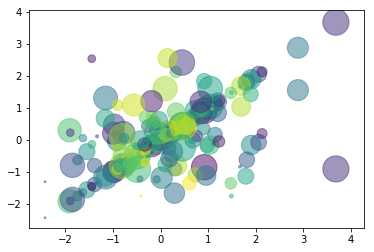

In [16]:
N = 104
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 0], s=area, c=colors, alpha=0.5)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], s=area, c=colors, alpha=0.5)
plt.show()